In [1]:
import numpy as np
import matplotlib as mpl
%matplotlib inline

import pandas as pd

import json
import glob
import os

import seaborn

In [2]:
data = {}

for path in glob.glob("../../data/results/all_real/*.json") + \
    glob.glob("../../data/results/all_real_seq/*.json") + \
    glob.glob("../../data/results/all_real_seq2/*.json") + \
    glob.glob("../../data/results/gossip_map/*.json") + \
    glob.glob("../../data/results/gossip_map2/*.json") + \
    glob.glob("../../data/results/louvain_baseline/*.json") + \
    glob.glob("../../data/results/infomap_baseline/*.json") + \
    glob.glob("../../data/results/all_real_cluster_cmp/*.json"):
  for typename, items in json.load(open(path)).items():
      if typename in data:
        for key, object_data in items.items():
          if key in data[typename]:
            data[typename][key].update(object_data)
          else:
            data[typename][key] = object_data
      else:
        data[typename] = items

frames = { typename: pd.DataFrame.from_dict(items, orient='index') for typename, items in data.items() }

In [3]:
dlslm_label = 'DSLM-Mod'
dlslm_me_label = 'DSLM-Map'
seq_postfix = ' w. Seq.'
no_contraction_postfix = ' w/o Contraction'
dlslm_ws_label = dlslm_label + seq_postfix
dlslm_nc_label = dlslm_label + no_contraction_postfix
seq_louvain_label = 'Seq. Louvain'
seq_infomap_label = 'Seq. InfoMap'
seq_infomap_directed_label = 'Seq. InfoMap directed'
plm_label = 'PLM'
relax_map_label = 'RelaxMap'
gossip_map_label = 'GossipMap'

algo_name_mapping = {
    'synchronous local moving with map equation': dlslm_me_label,
    'synchronous local moving with modularity': dlslm_label,
    'sequential louvain': seq_louvain_label,
    'sequential infomap': seq_infomap_label,
    'sequential directed infomap': seq_infomap_directed_label,
    'relax map': relax_map_label,
    'gossip map': gossip_map_label
}

frames['algorithm_run'].replace({ 'algorithm': algo_name_mapping }, inplace=True)

frames['algorithm_run']['algorithm'] += frames['algorithm_run'].merge(frames['program_run'], left_on='program_run_id', right_index=True, how='left')['switch_to_seq'].map({ False: '', True: seq_postfix, np.NaN: '' })
frames['algorithm_run']['algorithm'] += frames['algorithm_run'].merge(frames['program_run'], left_on='program_run_id', right_index=True, how='left')['contraction'].map({ False: no_contraction_postfix, True: '', np.NaN: '' })

In [4]:
frames['program_run']['graph_path'] = frames['program_run']['graph']

graph_names = { 
    'data/graphs/uk-2002.metis-preprocessed-*.bin': 'uk-2002', 
    'data/graphs/uk-2007-05.metis-preprocessed-*.bin': 'uk-2007-05', 
    'data/graphs/in-2004.metis-preprocessed-*.bin': 'in-2004', 
    'data/graphs/com-friendster-preprocessed-*.bin': 'friendster', 
    'data/graphs/com-lj.ungraph-preprocessed-*.bin': 'lj', 
    'data/graphs/com-orkut.ungraph-preprocessed-*.bin': 'orkut', 
    'data/graphs/com-youtube.ungraph-preprocessed-*.bin': 'youtube', 
    'data/graphs/com-amazon.ungraph-preprocessed-*.bin': 'amazon',
    'data/graphs/europe.osm-preprocessed-*.bin': 'osm-europe',
}

frames['program_run'].replace({ 'graph': graph_names }, inplace=True)

In [5]:
modularity_algos = [seq_louvain_label, plm_label, dlslm_label, dlslm_nc_label]
mapeq_algos = [seq_infomap_label, seq_infomap_directed_label, relax_map_label, gossip_map_label, dlslm_me_label]

dup = frames['clustering_comparison'].copy()
dup[['base_clustering_id', 'compare_clustering_id']] = frames['clustering_comparison'][['compare_clustering_id', 'base_clustering_id']]

data = frames['clustering_comparison'] \
    .append(dup) \
    .merge(frames['clustering'], left_on='base_clustering_id', right_index=True) \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .merge(frames['clustering'], left_on='compare_clustering_id', right_index=True) \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id_y', right_index=True) \
    .loc[lambda x: (x.path_x.str.contains('louvain_baseline') & x.algorithm_y.isin(modularity_algos)) | (x.path_x.str.contains('infomap_baseline') & x.algorithm_y.isin(mapeq_algos))]

comparison_data = data.groupby(['graph', 'algorithm_y'])['ARI'].mean().round(3).to_frame() \
    .unstack()["ARI"][modularity_algos + mapeq_algos]

res = comparison_data.loc[['lj', 'orkut', 'uk-2002', 'friendster',  'uk-2007-05']]
print(res.to_latex().replace('NaN', 'oom'))
res

\begin{tabular}{lrrrrrrrrr}
\toprule
algorithm\_y &  Seq. Louvain &    PLM &  DSLM-Mod &  DSLM-Mod w/o Contraction &  Seq. InfoMap &  Seq. InfoMap directed &  RelaxMap &  GossipMap &  DSLM-Map \\
graph      &               &        &           &                           &               &                        &           &            &           \\
\midrule
lj         &         0.568 &  0.570 &     0.500 &                     0.170 &         0.977 &                  0.974 &     0.373 &      0.780 &     0.767 \\
orkut      &         0.592 &  0.600 &     0.555 &                     0.212 &         0.930 &                  0.935 &     0.819 &      0.498 &     0.828 \\
uk-2002    &         0.717 &  0.712 &     0.663 &                     0.047 &         0.984 &                  0.984 &     0.928 &      0.698 &     0.968 \\
friendster &         0.609 &  0.619 &     0.575 &                     0.365 &           oom &                    oom &       oom &        oom &       oom \\
uk-2007-05

algorithm_y,Seq. Louvain,PLM,DSLM-Mod,DSLM-Mod w/o Contraction,Seq. InfoMap,Seq. InfoMap directed,RelaxMap,GossipMap,DSLM-Map
graph,,,,,,,,,
lj,0.568,0.570,0.500,0.170,0.977,0.974,0.373,0.780,0.767
orkut,0.592,0.600,0.555,0.212,0.930,0.935,0.819,0.498,0.828
uk-2002,0.717,0.712,0.663,0.047,0.984,0.984,0.928,0.698,0.968
friendster,0.609,0.619,0.575,0.365,NaN,NaN,NaN,NaN,NaN
uk-2007-05,0.875,0.882,0.823,0.281,NaN,NaN,NaN,NaN,NaN


In [9]:
all_data = frames['clustering'] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .groupby(['graph', 'algorithm'])['modularity'].mean().round(5).to_frame() \
    .unstack()["modularity"][modularity_algos + mapeq_algos]

all_data = all_data.loc[frames['program_run'].sort_values('edge_count')['graph'].dropna().unique()]

graph_data = frames['program_run'].dropna(subset=['hosts', 'edge_count']).groupby('graph').agg({ 'node_count': 'first', 'edge_count': 'first', 'hosts': 'max' })
graph_data['hosts'] = graph_data['hosts'].astype(int)
graph_data['edge_count'] = graph_data['edge_count'].astype(int)
graph_data.columns = ['n', 'm', 'hosts']
graph_data.sort_values('m').merge(all_data, left_index=True, right_index=True)

,n,m,hosts,Seq. Louvain,PLM,DSLM-Mod,DSLM-Mod w/o Contraction,Seq. InfoMap,Seq. InfoMap directed,RelaxMap,GossipMap,DSLM-Map
graph,,,,,,,,,,,,
amazon,334863,925872,2,NaN,NaN,0.92486,0.66281,NaN,NaN,NaN,0.82898,0.83069
youtube,1134890,2987624,2,NaN,NaN,0.72019,0.58012,NaN,NaN,NaN,0.56252,0.57475
in-2004,1382867,13591473,4,NaN,NaN,0.98009,0.87737,NaN,NaN,NaN,0.94278,0.93869
lj,3997962,34681189,8,0.75154,0.75225,0.74874,0.59073,0.64283,0.64322,0.60210,0.62695,0.62566
osm-europe,50912018,54054660,8,NaN,NaN,0.99889,0.48728,NaN,NaN,NaN,0.93818,0.93858
orkut,3072441,117185083,8,0.66351,0.66580,0.65841,0.52424,0.55879,0.55915,0.54033,0.54879,0.53847
uk-2002,18483186,261787258,8,0.98975,0.98971,0.98963,0.87904,0.95847,0.95854,0.96001,0.96330,0.95963
friendster,65608366,1806067135,16,0.62236,0.62698,0.61610,0.55288,NaN,NaN,NaN,0.22453,0.47257
uk-2007-05,105153952,3301876564,16,0.99625,0.99626,0.99619,0.91855,NaN,NaN,NaN,0.95316,0.97236


In [10]:
all_data = frames['clustering'] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .groupby(['graph', 'algorithm'])['map_equation'].mean().round(5).to_frame() \
    .unstack()["map_equation"][modularity_algos + mapeq_algos]

all_data = all_data.loc[frames['program_run'].sort_values('edge_count')['graph'].dropna().unique()]

graph_data = frames['program_run'].dropna(subset=['hosts', 'edge_count']).groupby('graph').agg({ 'node_count': 'first', 'edge_count': 'first', 'hosts': 'max' })
graph_data['hosts'] = graph_data['hosts'].astype(int)
graph_data['edge_count'] = graph_data['edge_count'].astype(int)
graph_data.columns = ['n', 'm', 'hosts']
graph_data.sort_values('m').merge(all_data, left_index=True, right_index=True)

,n,m,hosts,Seq. Louvain,PLM,DSLM-Mod,DSLM-Mod w/o Contraction,Seq. InfoMap,Seq. InfoMap directed,RelaxMap,GossipMap,DSLM-Map
graph,,,,,,,,,,,,
amazon,334863,925872,2,NaN,NaN,8.35257,6.42094,NaN,NaN,NaN,5.28859,5.30990
youtube,1134890,2987624,2,NaN,NaN,10.31650,9.44385,NaN,NaN,NaN,8.52810,8.54753
in-2004,1382867,13591473,4,NaN,NaN,7.28067,6.67116,NaN,NaN,NaN,6.41078,6.29794
lj,3997962,34681189,8,11.83368,11.82572,11.92705,10.44676,9.89925,9.89987,9.94310,9.96251,9.98095
osm-europe,50912018,54054660,8,NaN,NaN,9.95216,10.42852,NaN,NaN,NaN,4.35686,4.34971
orkut,3072441,117185083,8,12.94975,13.00040,12.96878,12.19252,11.82593,11.82527,11.84899,11.97924,11.89636
uk-2002,18483186,261787258,8,8.23305,8.24619,8.29748,7.04428,6.45790,6.45786,6.47612,6.55042,6.46789
friendster,65608366,1806067135,16,15.64728,15.61850,15.66436,15.30138,NaN,NaN,NaN,16.27057,14.78516
uk-2007-05,105153952,3301876564,16,9.07099,9.07414,9.12773,8.40233,NaN,NaN,NaN,9.03421,8.05733


In [32]:
all_data = frames['clustering'] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .groupby(['graph', 'algorithm'])['map_equation'].mean().to_frame() \
    .unstack()["map_equation"][[seq_louvain_label, plm_label, dlslm_label, dlslm_nc_label, seq_infomap_label, relax_map_label, gossip_map_label, dlslm_me_label]]

all_data = all_data.loc[frames['program_run'].sort_values('edge_count')['graph'].dropna().unique()]

graph_data = frames['program_run'].dropna(subset=['hosts', 'edge_count']).groupby('graph').agg({ 'node_count': 'first', 'edge_count': 'first', 'hosts': 'max' })
graph_data['hosts'] = graph_data['hosts'].astype(int)
graph_data.columns = ['n', 'm', 'hosts']
res = graph_data.sort_values('m').merge(all_data, left_index=True, right_index=True)

# with open("../../dist-thrill-cluster/plots/real_world_runtimes.tex", "w") as file:
print(res.to_latex())
res

\begin{tabular}{lrrrrrrrrrrr}
\toprule
{} &          n &             m &  hosts &  Seq. Louvain &        PLM &   DSLM-Mod &  DSLM-Mod w/o Contraction &  Seq. InfoMap &   RelaxMap &  GossipMap &   DSLM-Map \\
graph          &            &               &        &               &            &            &                           &               &            &            &            \\
\midrule
com-amazon     &     334863 &  9.258720e+05 &      2 &           NaN &        NaN &   8.352566 &                  6.420935 &           NaN &        NaN &   5.288590 &   5.309898 \\
com-youtube    &    1134890 &  2.987624e+06 &      2 &           NaN &        NaN &  10.316497 &                  9.443853 &           NaN &        NaN &   8.528098 &   8.547530 \\
in-2004        &    1382867 &  1.359147e+07 &      4 &           NaN &        NaN &   7.280668 &                  6.671164 &           NaN &        NaN &   6.410780 &   6.297943 \\
com-lj         &    3997962 &  3.468119e+07 &      8 &     

,n,m,hosts,Seq. Louvain,PLM,DSLM-Mod,DSLM-Mod w/o Contraction,Seq. InfoMap,RelaxMap,GossipMap,DSLM-Map
graph,,,,,,,,,,,
com-amazon,334863,9.258720e+05,2,NaN,NaN,8.352566,6.420935,NaN,NaN,5.288590,5.309898
com-youtube,1134890,2.987624e+06,2,NaN,NaN,10.316497,9.443853,NaN,NaN,8.528098,8.547530
in-2004,1382867,1.359147e+07,4,NaN,NaN,7.280668,6.671164,NaN,NaN,6.410780,6.297943
com-lj,3997962,3.468119e+07,8,11.831140,11.821780,11.927047,10.446759,9.898776,9.943972,9.964020,9.980945
osm-europe,50912018,5.405466e+07,8,NaN,NaN,9.952156,10.428523,NaN,NaN,4.356858,4.349715
com-orkut,3072441,1.171851e+08,8,12.944120,13.023040,12.968778,12.192524,11.825640,11.851120,11.976220,11.896358
uk-2002,18483186,2.617873e+08,8,8.227672,8.244208,8.297479,7.044281,6.457896,6.476128,6.499068,6.467886
com-friendster,65608366,1.806067e+09,16,15.647225,15.635840,15.664359,15.301383,NaN,NaN,16.227450,14.785157
uk-2007-05,105153952,3.301877e+09,16,9.073260,9.074660,9.127726,8.402328,NaN,NaN,8.387860,8.057326


In [18]:
all_data = frames['clustering'] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .groupby(['graph', 'algorithm'])['cluster_count'].mean().round(1).to_frame() \
    .unstack()["cluster_count"][[seq_louvain_label, plm_label, dlslm_label, dlslm_nc_label, seq_infomap_label, relax_map_label, gossip_map_label, dlslm_me_label]]

all_data = all_data.loc[frames['program_run'].sort_values('edge_count')['graph'].dropna().unique()]

graph_data = frames['program_run'].dropna(subset=['hosts', 'edge_count']).groupby('graph').agg({ 'node_count': 'first', 'edge_count': 'first', 'hosts': 'max' })
graph_data['hosts'] = graph_data['hosts'].astype(int)
graph_data.columns = ['n', 'm', 'hosts']
res = graph_data.sort_values('m').merge(all_data, left_index=True, right_index=True)

res['relative_change'] = (res[gossip_map_label] - res[seq_infomap_label]) / res[seq_infomap_label]
res

,n,m,hosts,Seq. Louvain,PLM,DSLM-Mod,DSLM-Mod w/o Contraction,Seq. InfoMap,RelaxMap,GossipMap,DSLM-Map,relative_change
graph,,,,,,,,,,,,
com-amazon,334863,9.258720e+05,2,NaN,NaN,229.9,58315.1,NaN,NaN,15525.0,14232.2,NaN
com-youtube,1134890,2.987624e+06,2,NaN,NaN,5228.5,210557.5,NaN,NaN,70122.2,52409.9,NaN
in-2004,1382867,1.359147e+07,4,NaN,NaN,925.6,104279.2,NaN,NaN,29672.2,27222.0,NaN
com-lj,3997962,3.468119e+07,8,1872.8,1802.8,1381.3,326716.3,85225.2,127836.0,122132.6,78016.0,0.433057
osm-europe,50912018,5.405466e+07,8,NaN,NaN,2746.1,22673150.8,NaN,NaN,2188946.8,2190102.1,NaN
com-orkut,3072441,1.171851e+08,8,36.8,19.6,27.7,34199.9,14733.8,25205.6,17233.6,15381.8,0.169664
uk-2002,18483186,2.617873e+08,8,4961.6,4712.0,4679.4,951448.9,198168.0,242450.0,213405.2,186627.0,0.076890
com-friendster,65608366,1.806067e+09,16,30448.0,26654.0,16925.3,1472293.1,NaN,NaN,1248011.5,584894.0,NaN
uk-2007-05,105153952,3.301877e+09,16,20234.7,20150.4,19856.8,2282674.0,NaN,NaN,579100.0,376449.5,NaN


ARI  \
compare_clustering_id                0cf800e1-6b1f-4167-a8e4-3cd598486af7   
base_clustering_id                                                          
2bb5a22c-9f99-4255-aeb4-38edefd83c59                             0.776388   
31adf1c0-aeac-49b1-a2fb-745a50093b75                             0.827440   
50d203c6-13ff-4921-9b6f-a9196209777d                             0.782528   
60868699-459a-4796-bcd0-f7c469a64084                             0.823233   
728044d5-75c2-47e4-86d7-7573aa9add31                             0.807150   
b940edd0-f25c-4d95-ab27-22094d74e6d2                             0.820472   
cb201ccc-5cd9-4fc5-97b5-7ef7fea839e6                             0.819147   
e0682069-6f72-42c7-b595-489e871b1058                             0.813013   
f6ee9db3-bf16-47f7-87df-73871a1b3e4f                             0.806572   
fa07a6a1-755d-4817-be4e-9a827d8303f0                             0.815790   
fb09dcd2-f232-4a69-b012-13e5f0550d9a                             0.817040   

                                                                           \
compare_clustering_id                26767262-6f80-47ed-b9ed-e694ba3e007d   
base_clustering_id                                                          
2bb5a22c-9f99-4255-aeb4-38edefd83c59                             0.788633   
31adf1c0-aeac-49b1-a2fb-745a50093b75                             0.822844   
50d203c6-13ff-4921-9b6f-a9196209777d                             0.797786   
60868699-459a-4796-bcd0-f7c469a64084                             0.819621   
728044d5-75c2-47e4-86d7-7573aa9add31                             0.826195   
b940edd0-f25c-4d95-ab27-22094d74e6d2                             0.835314   
cb201ccc-5cd9-4fc5-97b5-7ef7fea839e6                             0.820913   
e0682069-6f72-42c7-b595-489e871b1058                             0.820247   
f6ee9db3-bf16-47f7-87df-73871a1b3e4f                             0.835125   
fa07a6a1-755d-4817-be4e-9a827d8303f0                             0.831734   
fb09dcd2-f232-4a69-b012-13e5f0550d9a                             0.826659   

                                                                           \
compare_clustering_id                2676ffcc-5f4e-4e73-b534-3c21944edf87   
base_clustering_id                                                          
2bb5a22c-9f99-4255-aeb4-38edefd83c59                             0.780456   
31adf1c0-aeac-49b1-a2fb-745a50093b75                             0.835294   
50d203c6-13ff-4921-9b6f-a9196209777d                             0.792904   
60868699-459a-4796-bcd0-f7c469a64084                             0.812211   
728044d5-75c2-47e4-86d7-7573aa9add31                             0.812558   
b940edd0-f25c-4d95-ab27-22094d74e6d2                             0.817228   
cb201ccc-5cd9-4fc5-97b5-7ef7fea839e6                             0.815605   
e0682069-6f72-42c7-b595-489e871b1058                             0.809706   
f6ee9db3-bf16-47f7-87df-73871a1b3e4f                             0.820387   
fa07a6a1-755d-4817-be4e-9a827d8303f0                             0.816299   
fb09dcd2-f232-4a69-b012-13e5f0550d9a                             0.814535   

                                                                           \
compare_clustering_id                8055627d-8793-4a26-85ad-a61070806123   
base_clustering_id                                                          
2bb5a22c-9f99-4255-aeb4-38edefd83c59                             0.777419   
31adf1c0-aeac-49b1-a2fb-745a50093b75                             0.804867   
50d203c6-13ff-4921-9b6f-a9196209777d                             0.809914   
60868699-459a-4796-bcd0-f7c469a64084                             0.831300   
728044d5-75c2-47e4-86d7-7573aa9add31                             0.812357   
b940edd0-f25c-4d95-ab27-22094d74e6d2                             0.836868   
cb201ccc-5cd9-4fc5-97b5-7ef7fea839e6                             0.838537   
e0682069-6f72-42c7-b595-489e871b1058                           

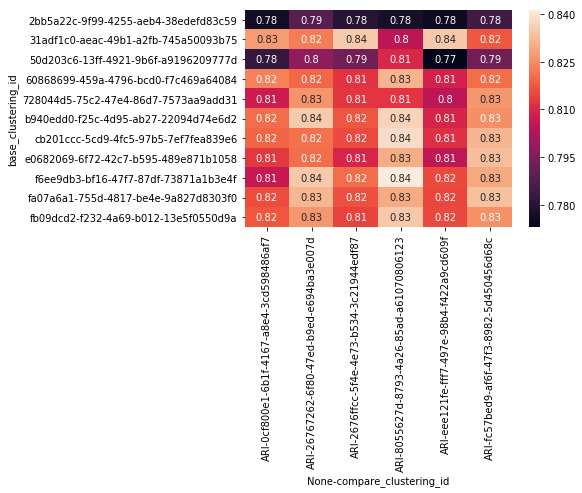

In [28]:
dup = frames['clustering_comparison'].copy()
dup[['base_clustering_id', 'compare_clustering_id']] = frames['clustering_comparison'][['compare_clustering_id', 'base_clustering_id']]

df = frames['clustering_comparison'] \
    .append(dup) \
    .merge(frames['clustering'], left_on='base_clustering_id', right_index=True) \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .merge(frames['clustering'], left_on='compare_clustering_id', right_index=True) \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id_y', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id_y', right_index=True) \
    .loc[lambda x: x.graph_x == 'uk-2007-05'] \
    .loc[lambda x: ((x.algorithm_x == dlslm_label) & (x.algorithm_y == seq_louvain_label))] \
    [['base_clustering_id', 'compare_clustering_id', 'ARI']] \
    .set_index(['base_clustering_id', 'compare_clustering_id']).unstack()

seaborn.heatmap(df, annot=True)
df

In [6]:
dup = frames['clustering_comparison'].copy()
dup[['base_clustering_id', 'compare_clustering_id']] = frames['clustering_comparison'][['compare_clustering_id', 'base_clustering_id']]

frames['clustering_comparison'] \
    .append(dup) \
    .merge(frames['clustering'], left_on='base_clustering_id', right_index=True) \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .merge(frames['clustering'], left_on='compare_clustering_id', right_index=True) \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id_y', right_index=True) \
    .loc[lambda x: ((x.algorithm_x == gossip_map_label) & (x.algorithm_y == dlslm_me_label))] \
    .groupby('graph')['ARI'].mean()

graph
amazon        0.737702
friendster    0.012046
in-2004       0.940228
lj            0.742477
orkut         0.465135
osm-europe    0.594620
uk-2002       0.699999
uk-2007-05    0.131403
youtube       0.623087
Name: ARI, dtype: float64

In [11]:
dup = frames['clustering_comparison'].copy()
dup[['base_clustering_id', 'compare_clustering_id']] = frames['clustering_comparison'][['compare_clustering_id', 'base_clustering_id']]

frames['clustering_comparison'] \
    .append(dup) \
    .merge(frames['clustering'], left_on='base_clustering_id', right_index=True) \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .merge(frames['clustering'], left_on='compare_clustering_id', right_index=True) \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id_y', right_index=True) \
    .loc[lambda x: ((x.algorithm_x == seq_louvain_label) & (x.algorithm_y == dlslm_me_label))] \
    .groupby('graph')['NMI'].mean()

graph
com-friendster    0.330746
com-lj            0.471689
com-orkut         0.408581
uk-2002           0.811166
uk-2007-05        0.883181
Name: NMI, dtype: float64